In this example we will map the geographic distribution of two South American mammals based on given past observations and 14 environmental variables (some direct affect the lifecycle of mammals and some do not). Since we have only positive examples (there are no unsuccessful observations in the training part, we will use), we cast this problem as a density estimation problem and use the OneClassSVM method provided by the packagescikits.learn.svmas in our modeling tool.

The dataset is provided by Phillips et. al. (2006). In most of the cases, the example uses base map to plot the coast lines and national boundaries of South America.

Species used in this dataset:

Bradypus Variegatus : The brown throated sloth.
Microryzomys Minutus : Also known as forest small rice rat, a rodent that lives in Peru, Colombia, Ecuador, Venejuala

Approach: Import necessary library for the algorithm.

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn import svm, metrics

Approach:  We have to check whether the base map is available, because if it is available, then we can not directly remove it, we have to handle all the base map conditions, otherwise we can just improvise it.

In [2]:
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

Approach: Construct the map grid from the batch object, which will used to plot the enviromnetal variable.

In [3]:
def construct_grids(batch):
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    ygrid = np.arange(ymin, ymax, batch.grid_size)
    return (xgrid, ygrid)

Approach: Create a bunch with information about a particular organism. This will use the test/train record arrays to extract the data specific to the given species name under specific condition.

In [4]:
def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    bunch = Bunch(name=" ".join(species_name.split("_")[:2]))
    species_name = species_name.encode("ascii")
    points = dict(test=test, train=train)
    for label, pts in points.items():
        pts = pts[pts["species"] == species_name]
        bunch["pts_%s" % label] = pts
        ix = np.searchsorted(xgrid, pts["dd long"])
        iy = np.searchsorted(ygrid, pts["dd lat"])
        bunch["cov_%s" % label] = coverages[:, -iy, ix].T
    return bunch

Approach:












*   We will plot the species distribution the distribution (density) curve;
We have to load the compressed data from the dataset.

*   We have to set up the data grid for x and y co-ordinates.

*   We have to create a bunch for each species and use the background points (grid coordinates) for evaluation.
*   We'll make use of the fact that coverages has measurements at all and points. This will help us decide between land and water.


*   We have to Fit, predict, and plot for each species and Standardize the features.


*   We have fitted using OneClassSVM and plot map of South America.

*   We will predict species distribution using the training data (using scatter points and only for land points).
*   We will compute AUC with regards to background points.







________________________________________________________________________________
Modeling distribution plot of species 'bradypus variegatus'
Fitting OneClassSVM ... Complete.
Plot coastlines from coverage
Predict species distribution

 Area under the ROC curve is: 0.868443
________________________________________________________________________________
Modeling distribution plot of species 'microryzomys minutus'
Fitting OneClassSVM ... Complete.
Plot coastlines from coverage
Predict species distribution

 Area under the ROC curve is: 0.993919

time elapsed: 30.46s


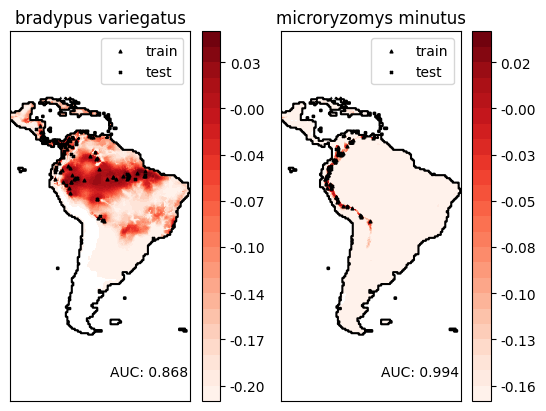

In [5]:
def plot_species_distribution(
    species=("bradypus_variegatus_0", "microryzomys_minutus_0")):
    if len(species) > 2:
        print("Note: when more than two species are provided,"
            " only the first two will be used")
    t0 = time()
    data = fetch_species_distributions()
    xgrid, ygrid = construct_grids(data)
    X, Y = np.meshgrid(xgrid, ygrid[::-1])
    BV_bunch = create_species_bunch(species[0], data.train, data.test, data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1], data.train, data.test, data.coverages, xgrid, ygrid)
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny, size=10000),np.random.randint(low=0, high=data.Nx, size=10000),].T
    land_reference = data.coverages[6]
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution plot of species '%s'" % species.name)
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std
        print("Fitting OneClassSVM ... ", end="")
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("Complete.")
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection="cyl",
                llcrnrlat=Y.min(),
                urcrnrlat=Y.max(),
                llcrnrlon=X.min(),
                urcrnrlon=X.max(),
                resolution="c",)
            m.drawcoastlines()
            m.drawcountries()
        else:
            print("Plot coastlines from coverage")
            plt.contour(X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print("Predict species distribution")
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T
        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred
        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format="%.2f")
        plt.scatter(species.pts_train["dd long"],
            species.pts_train["dd lat"],
            s=2**2,
            c="black",
            marker="^",
            label="train",)
        plt.scatter(species.pts_test["dd long"],
            species.pts_test["dd lat"],
            s=2**2,
            c="black",
            marker="x",
            label="test",)
        plt.legend()
        plt.title(species.name)
        plt.axis("equal")
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve is: %f" % roc_auc)
    print("\ntime elapsed: %.2fs" % (time() - t0))
plot_species_distribution()
plt.show()